In [9]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import time

In [34]:
env = gym.make('Blackjack-v1', natural=True, sab=False)


# ЧАСТЬ 1

### 1. Оцениваем выигрыш по простейшей стратегии из задания: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit.

In [31]:
# функция, генерирующая эпизод и возвращающая награду (на данный момент простейшая функция, без данных для обучения)
def run_episode(env):
    (player_sum, dealer_sum, us_ace), _ = env.reset()
    while player_sum < 19:
        ((player_sum, dealer_sum, us_ace), reward, trmn, _,_) = env.step(action=1)
        if trmn: # > 21
            return reward
    ((player_sum, dealer_sum, us_ace), reward, trmn, _,_) = env.step(action=0)
    return reward

In [39]:
t = time.time()
rewards = []
for i in range(1000000):
    rewards.append(run_episode(env))
print(time.time() - t)    

61.22091817855835


In [40]:
aver_reward = sum(rewards) / len(rewards)
print(aver_reward)

-0.1797055


### Итак, в среднем при такой стратегии казино выигрывает 0.18 очков

### 2. Строим модель MC control

In [43]:
# создаем словарь значение Q, которую будем обновлять и по которой будет определяться стратегия
def reset_Q():
    Q_vals = dict()
    for i in range(2, 32):
        for j in range(1, 11):
            for k in range(2):
                Q_vals[(i,j,k)] = {}
                for act in actions:
                    Q_vals[(i,j,k)][act] = {}
                    if i == 21 and act == 0: # случай usable ace
                        #Q_vals[(i,j,k)][act] = {}
                        Q_vals[(i,j,k)][act]["value"] = 1
                        Q_vals[(i,j,k)][act]["counts"] = 1

                    else:

                        Q_vals[(i,j,k)][act]["value"] = 0
                        Q_vals[(i,j,k)][act]["counts"] = 0
       
    return Q_vals

In [10]:
# определяем действие по стратегии (используем eps мягкую стратегию для исследования)
def action_step(state):
    if np.random.rand() < eps:
        action = np.random.choice(actions)
    else:
        v = -1e9
        for a in Q_vals[state]:
            #print("a = %d" %a)
            if Q_vals[state][a]["value"] > v:
                action = a
                v = Q_vals[state][a]["value"]
    #print(action)            
    return action

In [11]:
# генерируем эпизод
def run_episode(env):
    #states = list of ((player_sum, dealer_sum, usable_ace))
    states = []
    rewards = [0]
    ep_actions = []
    trmn = False
    #(player_sum, dealer_sum, us_ace), reward = env.reset()
    state, _ = env.reset()
    states.append(state)
    action = action_step(state)
    ep_actions.append(action)
    
    for i in range(100):
        (state, reward, trmn,_,_) = env.step(action=action)
        action = action_step(state)
        states.append(state)
        rewards.append(reward)
        ep_actions.append(action)
        if trmn:
            break        

    return [states, rewards, ep_actions]

In [12]:
# обновляем среднее значение в состоянии [state][action]
def update_unit(state, action, g): 
    #print("in update unit")
    #print(state, action)
    v_old = Q_vals[state][action]["value"]
    size = Q_vals[state][action]["counts"]
    v_new = (size * v_old + g) / (size + 1)
    size += 1
    Q_vals[state][action]["value"] = v_new
    Q_vals[state][action]["counts"] = size

In [13]:
# По сгенерированному эпизоду обновляем значения с словаре Q
def update_returns_actions(states, rewards, actions, n_iter):
    all_rewards[n_iter] = rewards[-1]
    #all_rewards.append(rewards[-1])
    g = 0
    #print("len of states = %d" %len(states))
    #print(states)
    #print(actions)
    #print(rewards)
    for t in range(len(states)-2, -1, -1):
        #print()
        g = g * gamma + rewards[t+1]
        update_unit(states[t], actions[t], g)

In [66]:
# Подсчет среднего значения дохода на отрезках вида [i-50000: i+50000]
def calc_mov_av(all_rewards, nbins=101, width=100000):
    aver_rewards = []
    
    inds = np.linspace(0, len(all_rewards), nbins)
    inds = inds[1:-1]
    inds = inds.astype("int")
    #print(inds)
    for i in inds:
        aver_rewards.append(np.mean(all_rewards[i-int(width/2):i+int(width/2)]))
    return [inds, aver_rewards]   

In [142]:
actions = [0, 1]
gamma = 0.9
eps = 0.1
Q_vals = reset_Q()

In [143]:
# Посмотрим на обучение для разных значений eps
N = 5000000
all_rewards = [None for i in range(N)]
t = time.time()

for n in range(N):
    [ep_states, ep_rewards, ep_actions] = run_episode(env)
    
    update_returns_actions(ep_states, ep_rewards, ep_actions, n)
    
    if n % 100000 == 0:
        print("iter %d" %n)
        print("elapsed time %f" %(time.time() - t))
print("total elapsed time %f" %(time.time() - t)) 

iter 0
elapsed time 0.000472
iter 100000
elapsed time 8.764338


KeyboardInterrupt: 

In [90]:
#inds_01, aver_rewards_eps_01 = calc_mov_av(all_rewards)

In [94]:
#inds_005, aver_rewards_eps_005 = calc_mov_av(all_rewards)

In [98]:
inds_001, aver_rewards_eps_001 = calc_mov_av(all_rewards)

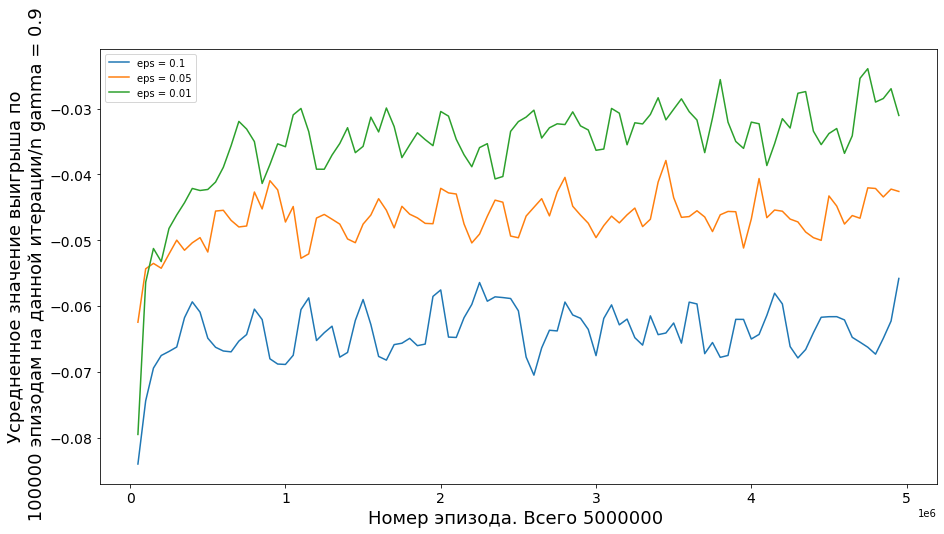

In [99]:
plt.figure(figsize=(15,8))
plt.plot(inds_01, aver_rewards_eps_01, label="eps = 0.1")
plt.plot(inds_005, aver_rewards_eps_005, label="eps = 0.05")
plt.plot(inds_001, aver_rewards_eps_001, label="eps = 0.01")
#plt.plot(inds, aver_rewards_eps_0, label="eps = 0.0")
plt.xlabel('Номер эпизода. Всего 5000000 ', fontsize=18)
plt.ylabel('Усредненное значение выигрыша по\n 100000 эпизодам на данной итерации/n gamma = 0.9', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.show()

### Рис. 1

### Итак, в зависимости от eps казино выигрывает в среднем 0.035 - 0.065 очков за игру vs 0.18 очков при простой стратегии из п.1.

## ЧАСТЬ 2

### Добавление действия double

### Для реализации воспользуемся кодом для класса BlackjackEnv и немного его переделаем. А именно, добавим множитель self.mult, изначально равный 1, а в случае, если action=2 (данная цифра будет обозначать действие double ), self.mult=2. В случае конца эпизода будем возвращать reward*self.mult
(код взят с https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py)

In [101]:
import os
from typing import Optional

import numpy as np

import gym
from gym import spaces
from gym.error import DependencyNotInstalled


def cmp(a, b):
    return float(a > b) - float(a < b)


# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackEnv(gym.Env):

    metadata = {
        "render_modes": ["human", "rgb_array"],
        "render_fps": 4,
    }

    def __init__(self, render_mode: Optional[str] = None, natural=False, sab=False):
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple(
            (spaces.Discrete(32), spaces.Discrete(11), spaces.Discrete(2))
        )

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural

        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = sab

        self.render_mode = render_mode
        
        self.mult = 1   # множитель, =2 в случае удвоения ставки, =1 иначе

    def step(self, action):
        #assert self.action_space.contains(action)
        if action > 0:  # hit: add a card to players hand and return
            if action == 2:     # если делаем double, ставим множитель награды = 2
                #print("action=2")
                self.mult = 2   # 
                #print("in section action=2, slef.mult=", self.mult)
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                terminated = True
                reward = -1.0 * self.mult # домножаем награду
            else:
                terminated = False
                reward = 0.0
            #if action == 2:
                #res = self.step(0)
                #print("res= ", res)
                #return res
        if action == 0 or self.mult == 2:  # stick: play out the dealers hand, and score
            #print("in section action=0, self.mult= ", self.mult)
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer)) * self.mult  # домножаем награду
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0 * self.mult
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0 * self.mult
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), reward, terminated, False, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(
        self,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        self.mult = 1

        _, dealer_card_value, _ = self._get_obs()

        suits = ["C", "D", "H", "S"]
        self.dealer_top_card_suit = self.np_random.choice(suits)

        if dealer_card_value == 1:
            self.dealer_top_card_value_str = "A"
        elif dealer_card_value == 10:
            self.dealer_top_card_value_str = self.np_random.choice(["J", "Q", "K"])
        else:
            self.dealer_top_card_value_str = str(dealer_card_value)

        if self.render_mode == "human":
            self.render()
        return self._get_obs(), {}

    

    def close(self):
        if hasattr(self, "screen"):
            import pygame

            pygame.display.quit()
            pygame.quit()

In [79]:
def reset_Q():
    Q_vals = dict()
    for i in range(2, 32):
        for j in range(1, 11):
            for k in range(2):
                Q_vals[(i,j,k)] = {}
                for act in actions:
                    Q_vals[(i,j,k)][act] = {}
                    if i == 21 and act == 0:
                        #Q_vals[(i,j,k)][act] = {}
                        Q_vals[(i,j,k)][act]["value"] = 1
                        Q_vals[(i,j,k)][act]["counts"] = 1

                    else:

                        Q_vals[(i,j,k)][act]["value"] = 0
                        Q_vals[(i,j,k)][act]["counts"] = 0
    return Q_vals 

In [146]:
env = BlackjackEnv(natural=True)

### Добавим еще один action = 2 - обозначает удвоение ставки double

In [156]:
actions = [0, 1, 2]
gamma = 0.9
eps = 0.05
Q_vals = reset_Q()
env = BlackjackEnv(natural=True)


### Обучаемся:

In [157]:
N = 5000000
all_rewards = [None for i in range(N)]
t = time.time()

for n in range(N):
    [ep_states, ep_rewards, ep_actions] = run_episode(env)
    
    update_returns_actions(ep_states, ep_rewards, ep_actions, n)
    
    if n % 100000 == 0:
        print("iter %d" %n)
        print("elapsed time %f" %(time.time() - t))
print("total elapsed time %f" %(time.time() - t))  

iter 0
elapsed time 0.000587
iter 100000
elapsed time 7.909559
iter 200000
elapsed time 18.482272
iter 300000
elapsed time 27.785651
iter 400000
elapsed time 36.109658
iter 500000
elapsed time 43.805269
iter 600000
elapsed time 51.682771
iter 700000
elapsed time 60.005316
iter 800000
elapsed time 68.153442
iter 900000
elapsed time 76.104208
iter 1000000
elapsed time 84.023274
iter 1100000
elapsed time 92.170470
iter 1200000
elapsed time 100.003126
iter 1300000
elapsed time 108.095146
iter 1400000
elapsed time 116.395033
iter 1500000
elapsed time 124.564420
iter 1600000
elapsed time 132.480061
iter 1700000
elapsed time 140.686873
iter 1800000
elapsed time 148.629258
iter 1900000
elapsed time 156.509618
iter 2000000
elapsed time 164.572262
iter 2100000
elapsed time 172.598012
iter 2200000
elapsed time 180.660703
iter 2300000
elapsed time 188.746138
iter 2400000
elapsed time 196.822263
iter 2500000
elapsed time 204.750624
iter 2600000
elapsed time 212.706115
iter 2700000
elapsed time 220.

In [154]:
#inds_double, aver_rewards_eps_01_double = calc_mov_av(all_rewards)

In [158]:
inds_double, aver_rewards_eps_005_double = calc_mov_av(all_rewards)

In [150]:
#inds_double, aver_rewards_eps_001_double = calc_mov_av(all_rewards)

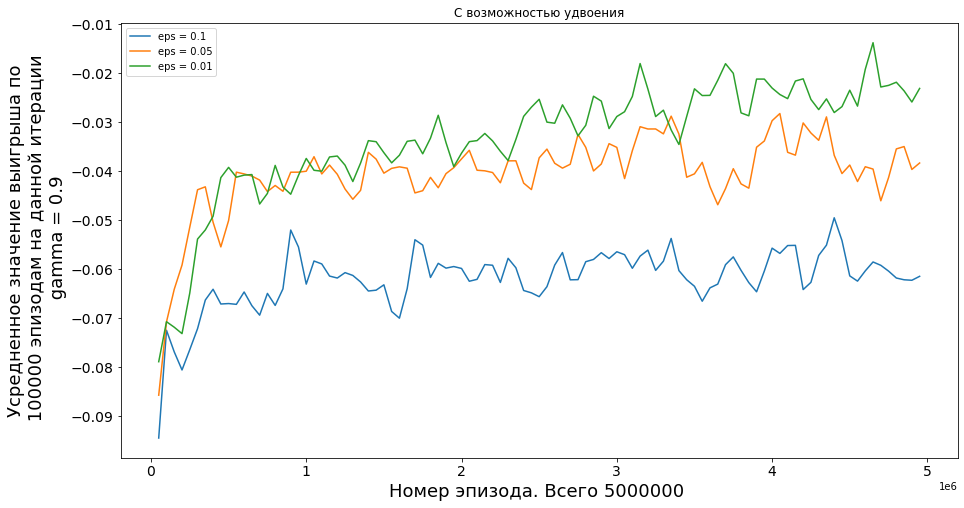

In [159]:
plt.figure(figsize=(15,8))
plt.plot(inds_double, aver_rewards_eps_01_double, label="eps = 0.1")
#plt.plot(inds, aver_rewards_eps_01, label="eps = 0.1 no double")
plt.plot(inds_double, aver_rewards_eps_005_double, label="eps = 0.05")
plt.plot(inds_double, aver_rewards_eps_001_double, label="eps = 0.01")
plt.xlabel('Номер эпизода. Всего 5000000 ', fontsize=18)
plt.ylabel('Усредненное значение выигрыша по\n 100000 эпизодам на данной итерации\n gamma = 0.9', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("С возможностью удвоения")
plt.legend()
plt.show()

### Видно, что при добавлении удвоения ставки выигрыш казино немного уменьшился
### Также, видно, что при eps = 0.05 и 0.01для сходимости нужно больше шагов. Особенно выражено для eps=0.01 (см график ниже для eps=0.01), когда изначально выигрыш казино выше в случае возможности удвоения, но со временем он становится меньше, чем без возможности удвоения
### Для удобства сравнения отобразим пары кривых для одного значения eps:

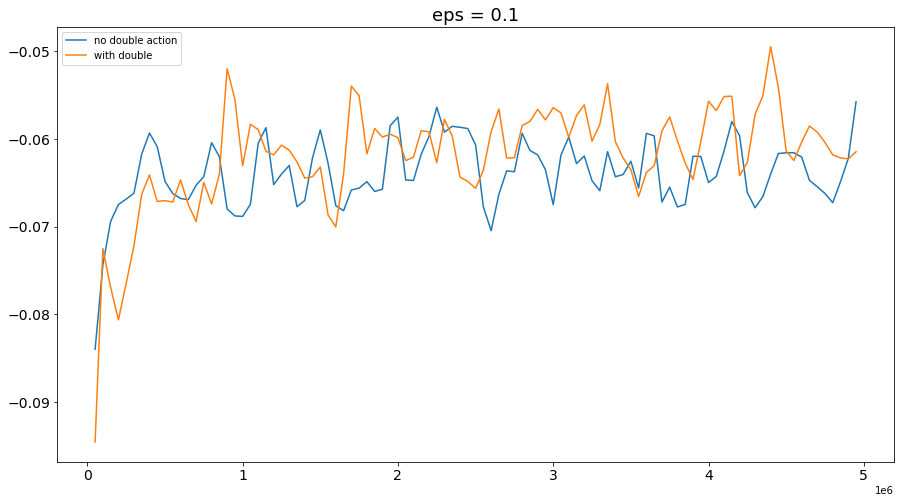

In [168]:
plt.figure(figsize=(15,8))
plt.plot(inds_01, aver_rewards_eps_01, label="no double action")
plt.plot(inds_double, aver_rewards_eps_01_double, label="with double")
plt.title("eps = 0.1", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.show()

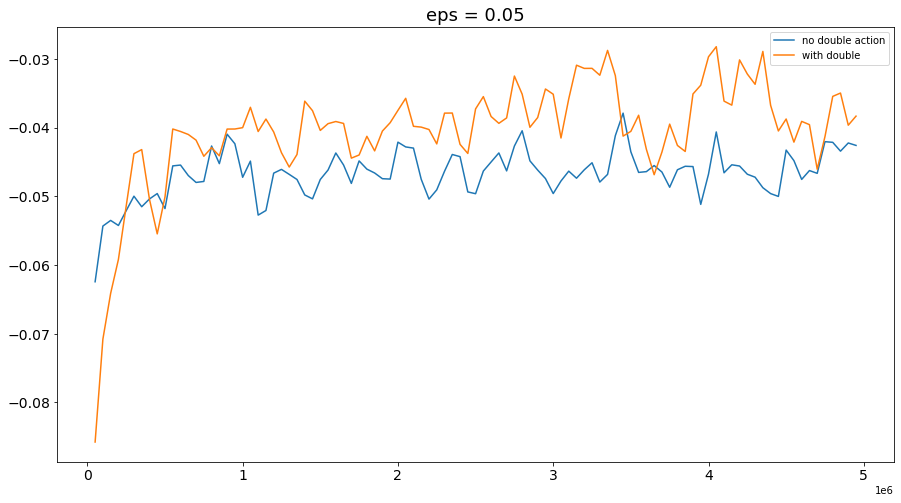

In [169]:
plt.figure(figsize=(15,8))
plt.plot(inds_005, aver_rewards_eps_005, label="no double action")
plt.plot(inds_double, aver_rewards_eps_005_double, label="with double")
plt.title("eps = 0.05", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.show()

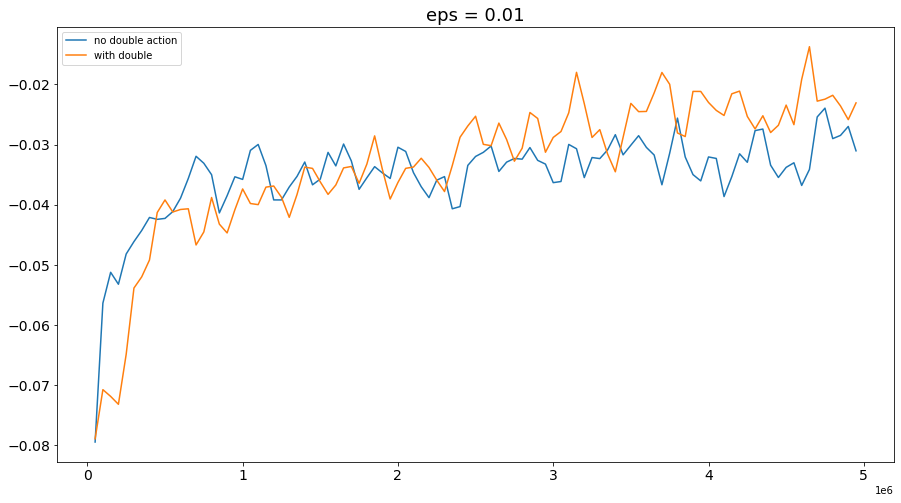

In [170]:
plt.figure(figsize=(15,8))
plt.plot(inds_001, aver_rewards_eps_001, label="no double action")
plt.plot(inds_double, aver_rewards_eps_001_double, label="with double")
plt.title("eps = 0.01", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.show()

## Итак, видно, что при добавлении возможности удвоения казино "зарабатывает" чуть меньше, но по-прежнему оно в выигрыше. Интересная динамика для eps=0.01, когда вначале казино выгрывает больше при наличии удвоения, и спустя довольно большое количество эпизодов (2-2.5 млн) казино получает меньше, чем без возможности удвоения.Скорее всего, для других значений eps аналогичная ситуация, но в силу более быстрой сходимости это мало заметно на данных графиках

## ЧАСТЬ 3